In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import statistics


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('mps')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

if __name__ == '__main__':
    plot = []
    env = gym.make('LunarLander-v2')
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
                  input_dims=[8], lr=0.001)
    scores, eps_history = [], []
    n_games = 500
    
    for i in trange(n_games):
        score = 0
        done = False
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = statistics.mean(np.array(scores[-100:]))
        plot.append(avg_score)
        # # print('episode ', i, 'score %.2f' % score,
        #         'average score %.2f' % avg_score,
        #         'epsilon %.2f' % agent.epsilon)
    x = [i+1 for i in range(n_games)]
    filename = 'lunar_lander.png'
    # plt.plot(x, scores, eps_history)


/Users/charlie/.conda/envs/py39/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/4y/y2r7rtj90w50wr7fv5zd3vkh0000gp/T/ipykernel_4631/1171886190.py:102: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  q_next[terminal_batch] = 0.0
  0%|          | 1/500 [00:00<02:19,  3.57it/s]/var/folders/4y/y2r7rtj90w50wr7fv5zd3vkh0000gp/T/ipykernel_4631/1171886190.py:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered i

KeyboardInterrupt: 

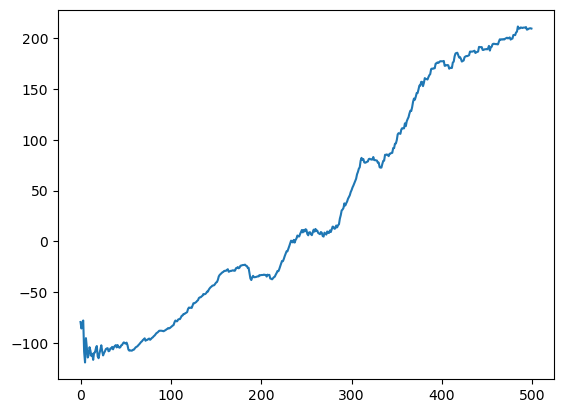

In [ ]:
plt.plot(plot)